# Named entity recognition in spaCy
Kate Riesbeck  
19 May 2020  
  
   
This notebook reviews named entity recognition (NER) in spaCy with:
* Pretrained spaCy models
* Customized NER with:
 * Rule-based matching
 * Custom trained models

## Setup

pip install requirements.txt

In [1]:
import spacy
from spacy import displacy
from IPython.display import Image

## NER with spaCy's pretrained models

In [2]:
# load a pretrained spaCy model

nlp = spacy.load('en_core_web_sm')

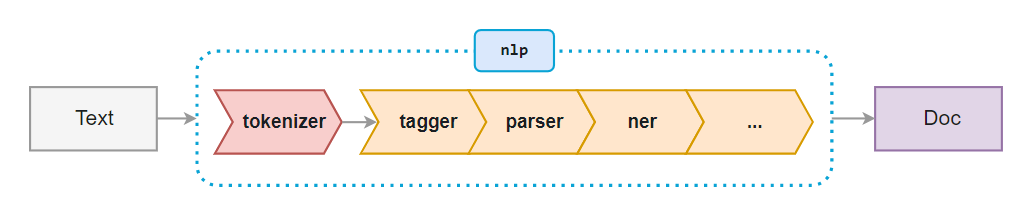

In [3]:
Image(filename = 'images/pipeline.png', width=1000, height=1000)

The pretrained model comes with a default processing pipeline that includes part-of-speech tagging, syntactic parsing, and NER.  The pretrained models are statistical and every “decision” they make is a prediction based on the examples the model has seen during training.  

The pipeline...

In [4]:
# View pipeline components
nlp.pipe_names

['tagger', 'parser', 'ner']

In [5]:
text = """George Washington (February 22, 1732[b] – December 14, 1799) was an American political leader, 
military general, statesman, and founding father who served as the first president of the United States 
from 1789 to 1797. Previously, he led Patriot forces to victory in the nation's War for Independence. 
He presided at the Constitutional Convention of 1787, which established the U.S. Constitution and a federal government. 
Washington has been called the "Father of His Country" for his manifold leadership in the formative days of the new nation.
"""

In [6]:
# run the text through the pretrained model

doc = nlp(text)

In [7]:
# the NER pipeline component tags entities in the doc with various attributes

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

George Washington 0 17 PERSON
February 22 19 30 DATE
December 14, 1799 42 59 DATE
American 68 76 NORP
first 163 168 ORDINAL
the United States 182 199 GPE
1789 to 1797 206 218 DATE
Patriot 239 246 PERSON
War for Independence 281 301 EVENT
the Constitutional Convention 319 348 LAW
1787 352 356 DATE
the U.S. Constitution 376 397 LAW
Washington 425 435 GPE
the "Father of His Country" 452 479 LAW
the formative days 511 529 DATE


In [8]:
spacy.explain('NORP')

'Nationalities or religious or political groups'

In [9]:
# use displacy to visualize entities

displacy.render(doc, style='ent')

## How does the pretrained NER model work?

spaCy uses residual convolutional neural networks (CNNs) and incremental parsing with Bloom embeddings for NER. 

See this Youtube explanation from the developers for more detail: https://www.youtube.com/watch?v=sqDHBH9IjRU (start at 8:20)

SpaCy's pretrained models are trained on the OntoNotes5 corpus, and support the identification of the following entities:

| TYPE | DESCRIPTION |
| --- | ------- |
| PERSON |People, including fictional. |
| NORP | Nationalities or religious or political groups. |
| FAC | Buildings, airports, highways, bridges, etc. |
| ORG | Companies, agencies, institutions, etc. |
| GPE | Countries, cities, states. |
| LOC | Non-GPE locations, mountain ranges, bodies of water. |
| PRODUCT | Objects, vehicles, foods, etc. (Not services.) |
| EVENT | Named hurricanes, battles, wars, sports events, etc. |
| WORK_OF_ART | Titles of books, songs, etc. |
| LAW | Named documents made into laws. |
| LANGUAGE | Any named language. |
| DATE | Absolute or relative dates or periods. |
| TIME | Times smaller than a day. |
| PERCENT | Percentage, including ”%“. |
| MONEY | Monetary values, including unit. |
| QUANTITY | Measurements, as of weight or distance. |
| ORDINAL | “first”, “second”, etc. |
| CARDINAL | Numerals that do not fall under another type. |


## How can I customize NER in spaCy for my use case?

1. Add rule-based matching
 * Useful if there’s a finite number of examples that you want to find in the data, or if there’s a very clear, structured pattern
 * For instance, country names, IP addresses or URLs
2. Train a custom model
 * Useful if you have examples and you want your system to generalize based on those examples
 * Works especially well if there are clues in the local context
 * For instance, person or company names

You can also combine both approaches and improve a model with rules to handle very specific cases and boost accuracy.

## Rule-based matching with EntityRuler

 * Useful if there’s a finite number of examples that you want to find in the data, or if there’s a very clear, structured pattern
 * For instance, country names, IP addresses or URLs

SpaCy's EntityRuler is a pipeline component that lets you add named entities based on pattern dictionaries, and makes it easy to combine rule-based and statistical NER for more powerful models.


The entity ruler integrates with spaCy’s existing statistical models and enhances the named entity recognizer. 



In [10]:
from spacy.pipeline import EntityRuler

In [11]:
ruler = EntityRuler(nlp)

In [12]:
#### PATTERNS

# https://spacy.io/api/entityruler#add_patterns

# Entity Patterns

# Entity patterns are dictionaries with two keys: 
# 1. "label", the label to assign to the entity
# 2. "pattern", the match pattern. 

# The entity ruler accepts two types of patterns:
# 1. Phrase patterns for exact string matches
# 2. Token patterns with one pattern dictionary per token

In [13]:
# **Phrase patterns**

# Here is a phrase pattern example:
# patterns = [{"label": "PRES", "pattern": "George Washington"}]

In [14]:
ruler.add_patterns([{"label": "PRES", "pattern": "George Washington"}])

In [15]:
# Add EntityRuler pipeline component to the nlp model pipeline before the existing 'ner' pipeline

# Important: If the EntityRuler is added before the "ner" component,'ner' will respect the EntityRuler labels 
# and adjust its predictions.  This is what we want.

# If it’s added after the "ner" component, the EntityRuler will only tag entities if they don’t overlap 
# with entities predicted by 'ner'. To overwrite overlapping entities, you can set overwrite_ents=True on initialization.

nlp.add_pipe(ruler, before='ner', name='presidents')

In [16]:
nlp.pipe_names

['tagger', 'parser', 'presidents', 'ner']

In [17]:
# run the text through the new model pipeline

doc = nlp(text)

In [18]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

George Washington 0 17 PRES
February 22 19 30 DATE
December 14, 1799 42 59 DATE
American 68 76 NORP
first 163 168 ORDINAL
the United States 182 199 GPE
1789 to 1797 206 218 DATE
Patriot 239 246 PERSON
War for Independence 281 301 EVENT
the Constitutional Convention 319 348 LAW
1787 352 356 DATE
the U.S. Constitution 376 397 LAW
Washington 425 435 GPE
the "Father of His Country" 452 479 LAW
the formative days 511 529 DATE


In [19]:
displacy.render(doc, style='ent')

In [20]:
# Let's add more patterns
# Starting with a list of president names
presidents = ["Donald Trump" , "Barack Obama" , "George W. Bush" , "Bill Clinton" , "George H.W. Bush" , "Ronald Reagan" , "Jimmy Carter" , "Gerald Ford" , "Richard Nixon" , "Lyndon B. Johnson" , "John F. Kennedy" , "Dwight D. Eisenhower", "Harry S. Truman" , "Franklin D. Roosevelt" , "Herbert Hoover" , "Calvin Coolidge" , "Warren G. Harding" , "Woodrow Wilson" , "Howard Taft" , "Theodore Roosevelt" , "William McKinley" , "Grover Cleveland" , "Benjamin Harrison" , "Grover Cleveland" , "Chester A. Arthur" , "James Garfield" , "Rutherford B. Hayes" , "Ulysses S. Grant" , "Andrew Johnson" , "Abraham Lincoln" , "James Buchanan" , "Franklin Pierce" , "Millard Fillmore", "Zachary Taylor" , "James K. Polk" , "John Tyler" , "William Henry Harrison" , "Martin Van Buren" , "Andrew Jackson" , "John Quincy Adams" , "James Monroe" , "James Madison" , "Thomas Jefferson" , "John Adams"]

In [21]:
# Write a function to turn the list into spaCy's entity pattern list of dictionaries format
def make_patterns(my_list, my_label):
    """
    turns a list of strings into a list of patterns with the same label for spaCy's EntityRuler
    """
    patterns = []
    for i in my_list:
        d = {}
        d['label'] = my_label
        d['pattern'] = i
        patterns.append(d)
    return patterns    

In [22]:
# Create the patterns
patterns = make_patterns(presidents, "PRES")

In [23]:
# Verify pattern format -- a list of dictionaries
patterns[:10]

[{'label': 'PRES', 'pattern': 'Donald Trump'},
 {'label': 'PRES', 'pattern': 'Barack Obama'},
 {'label': 'PRES', 'pattern': 'George W. Bush'},
 {'label': 'PRES', 'pattern': 'Bill Clinton'},
 {'label': 'PRES', 'pattern': 'George H.W. Bush'},
 {'label': 'PRES', 'pattern': 'Ronald Reagan'},
 {'label': 'PRES', 'pattern': 'Jimmy Carter'},
 {'label': 'PRES', 'pattern': 'Gerald Ford'},
 {'label': 'PRES', 'pattern': 'Richard Nixon'},
 {'label': 'PRES', 'pattern': 'Lyndon B. Johnson'}]

In [24]:
# Add the patterns to the EntityRuler pipeline component
ruler.add_patterns(patterns)

In [25]:
# Check to make sure our new patterns were added to the EntityRuler
ruler.patterns[:10]

[{'label': 'PRES', 'pattern': 'George Washington'},
 {'label': 'PRES', 'pattern': 'Donald Trump'},
 {'label': 'PRES', 'pattern': 'Barack Obama'},
 {'label': 'PRES', 'pattern': 'George W. Bush'},
 {'label': 'PRES', 'pattern': 'Bill Clinton'},
 {'label': 'PRES', 'pattern': 'George H.W. Bush'},
 {'label': 'PRES', 'pattern': 'Ronald Reagan'},
 {'label': 'PRES', 'pattern': 'Jimmy Carter'},
 {'label': 'PRES', 'pattern': 'Gerald Ford'},
 {'label': 'PRES', 'pattern': 'Richard Nixon'}]

In [26]:
# Remove existing 'presidents' pipe
nlp.remove_pipe('presidents');

In [27]:
# Add updated EntityRuler pipeline component to the nlp model pipeline
nlp.add_pipe(ruler, before='ner', name='presidents')

In [28]:
doc = nlp("George H.W. Bush (June 12, 1924 – November 30, 2018) was an American politician and businessman \
          who served as the 41st president of the United States from 1989 to 1993.")

In [29]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

George H.W. Bush 0 16 PRES
June 12, 1924 18 31 DATE
November 30, 2018 34 51 DATE
American 60 68 NORP
41st 124 128 ORDINAL
the United States 142 159 GPE
1989 to 1993 165 177 DATE


In [30]:
displacy.render(doc, style='ent')

In [31]:
## 

In [32]:
doc = nlp("George Herbert Walker Bush (June 12, 1924 – November 30, 2018) was an American politician and businessman \
          who served as the 41st president of the United States from 1989 to 1993.")

In [33]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

George Herbert Walker Bush 0 26 PERSON
June 12, 1924 28 41 DATE
November 30, 2018 44 61 DATE
American 70 78 NORP
41st 134 138 ORDINAL
the United States 152 169 GPE
1989 to 1993 175 187 DATE


In [34]:
displacy.render(doc, style='ent')

In [35]:
# remove existing 'presidents' pipe and reset EntityRuler

nlp.remove_pipe('presidents')

ruler = EntityRuler(nlp)

patterns = []

In [36]:
# **Token patterns**

# 

# patterns = [{"label": "PRES", "pattern": "George H.W. Bush"},
#            {"label": "VP", "pattern": [{"LOWER": "al"}, {"LOWER": "gore"}]}]


In [37]:
# we can craft more inclusive patterns with regex
# note the ruler evaluates by token

In [38]:
# 2 tokens (like george bush)
patterns.append({"id":"PRES41", "label": "PRES", "pattern": [{"LOWER": 'george'}, {"LOWER": 'bush'}]})

# 3 tokens (like george hw bush, george h.w. bush)
patterns.append({"id":"PRES41", "label": "PRES", "pattern": [{"LOWER": 'george'}, {"LOWER": {"REGEX": '(h(w|.w.)?)'}}, {"LOWER":  'bush'}]})

# 4 tokens (like george h w bush, george h. w. bush, george herbert walker bush)
patterns.append({"id":"PRES41", "label": "PRES", "pattern": [{"LOWER": 'george'}, {"LOWER": {"REGEX": '(h(.|erbert)?)'}}, {"LOWER": {"REGEX": '(w(.|alker)?)'}}, {"LOWER":  'bush'}]})

In [39]:
ruler.add_patterns(patterns)

In [40]:
nlp.add_pipe(ruler, before='ner', name='presidents')

In [44]:
doc = nlp("George Herbert Walker Bush was an American politician and businessman \
          who served as the 41st president of the United States from 1989 to 1993. \
          His son, George W. Bush, served as the 43rd president of the United States. \
          Known names: George H.W. Bush, George H. W. Bush, George HW Bush, George H W Bush, George Bush")

In [45]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

George Herbert Walker Bush 0 26 PRES
American 34 42 NORP
41st 98 102 ORDINAL
the United States 116 133 GPE
1989 to 1993 139 151 DATE
George W. Bush 172 186 PERSON
43rd 202 206 ORDINAL
the United States 220 237 GPE
George H.W. Bush 262 278 PRES
George H. W. Bush 280 297 PRES
George HW Bush 299 313 PRES
George H W Bush 315 330 PRES
George Bush 332 343 PRES


In [43]:
displacy.render(doc, style='ent')

## Train a custom model
 * Useful if you have examples and you want your system to generalize based on those examples
 * Works especially well if there are clues in the local context
 * For instance, person or company names
 
Note:  Requires a labeled dataset (at least a few hundred, more is better)

In [60]:
from spacy.util import minibatch, compounding
import random

In [61]:
# data

In [62]:
# new entity label
LABEL = "ANIMAL"

In [63]:
# training data

TRAIN_DATA = [
    (
        "Horses are too tall and they pretend to care about your feelings",
        {"entities": [(0, 6, LABEL)]},
    ),
    ("Do they bite?", {"entities": []}),
    (
        "horses are too tall and they pretend to care about your feelings",
        {"entities": [(0, 6, LABEL)]},
    ),
    ("horses pretend to care about your feelings", {"entities": [(0, 6, LABEL)]}),
    (
        "they pretend to care about your feelings, those horses",
        {"entities": [(48, 54, LABEL)]},
    ),
    ("horses?", {"entities": [(0, 6, LABEL)]}),
]

### Run data through existing/default NER pipeline before training

This prevents "catastrophic forgetting," a phenomenon where the model "forgets" what it previously knew.  
See: https://explosion.ai/blog/pseudo-rehearsal-catastrophic-forgetting



In [64]:
# Format data for labelling

### Format data for training

https://spacy.io/api/annotation#named-entities

spaCy takes training data in JSON format. The built-in convert command helps you convert the .conllu format used by the Universal Dependencies corpora to spaCy’s training format. To convert one or more existing Doc objects to spaCy’s JSON format, you can use the gold.docs_to_json helper.

In [76]:
doc = Doc(nlp.vocab, ["rats", "make", "good", "pets"])
gold = GoldParse(doc, entities=["U-ANIMAL", "O", "O", "O"])

NameError: name 'Doc' is not defined

### Train model on new + existing labels

In [65]:
# Because we know the correct answer, we can give the model feedback on its prediction 
# in the form of an error gradient of the loss function that calculates the difference 
# between the training example and the expected output. 
# The greater the difference, the more significant the gradient and the updates to our model.

# When training a model, we don’t just want it to memorise our examples — 
# we want it to come up with theory that can be generalised across other examples. 
# After all, we don’t just want the model to learn that this one instance of “Amazon” right here is a company — 
# we want it to learn that “Amazon”, in contexts like this, is most likely a company. 
# In order to tune the accuracy, we process our training examples in batches, 
# and experiment with minibatch sizes and dropout rates.

# Of course, it’s not enough to only show a model a single example once. 
# Especially if you only have few examples, you’ll want to train for a number of iterations. 
# At each iteration, the training data is shuffled to ensure the model doesn’t make any generalisations 
# based on the order of examples.

# Another technique to improve the learning results is to set a dropout rate, 
# a rate at which to randomly “drop” individual features and representations. 
# This makes it harder for the model to memorise the training data. 
# For example, a 0.25dropout means that each feature or internal representation has a 1/4 likelihood of being dropped. 
# We train the model for 10 epochs and keep the dropout rate as 0.2.
# See: # https://github.com/DataTurks-Engg/Entity-Recognition-In-Resumes-SpaCy

In [66]:
# Shuffle and loop over the examples. 
# For each example, update the model by calling nlp.update, which steps through the words of the input. 
# At each word, it makes a prediction. It then consults the annotations to see whether it was right. 
# If it was wrong, it adjusts its weights so that the correct action will score higher next time.

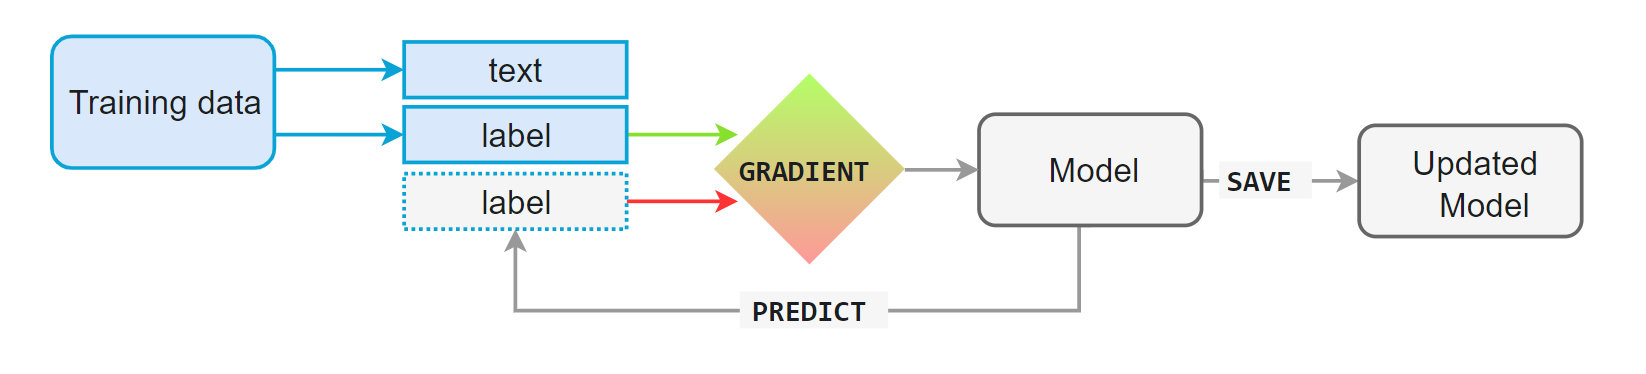

In [77]:
Image(filename = 'images/training.png', width=1000, height=1000)

**Training data**: Examples and their annotations.  
**Text**: The input text the model should predict a label for.  
**Label**: The label the model should predict.  
**Gradient**: Gradient of the loss function calculating the difference between input and expected output.

In [71]:
model='en_core_web_sm'
new_model_name="animal"
n_iter=30

"""Set up the pipeline and entity recognizer, and train the new entity."""
random.seed(0)

nlp = spacy.load(model)  # load existing spaCy model
print("Loaded model '%s'" % model)

Loaded model 'en_core_web_sm'


In [72]:
# select default entity recognizer, so we can add labels to it
ner = nlp.get_pipe("ner")

ner.add_label(LABEL)  # add new entity label to entity recognizer

In [73]:
optimizer = nlp.resume_training()

move_names = list(ner.move_names)

# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in 'ner']

# only train NER
with nlp.disable_pipes(*other_pipes):

    sizes = compounding(1.0, 4.0, 1.001)
    # batch up the examples using spaCy's minibatch
    for itn in range(n_iter):
        random.shuffle(TRAIN_DATA)
        batches = minibatch(TRAIN_DATA, size=sizes)
        losses = {}
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)
        print("Losses", losses)

Losses {'ner': 17.85687353592493}
Losses {'ner': 20.20731796844052}
Losses {'ner': 18.50244914857467}
Losses {'ner': 22.460931794092176}
Losses {'ner': 20.92218860283583}
Losses {'ner': 29.591351133218268}
Losses {'ner': 21.29363500321051}
Losses {'ner': 19.5912634281558}
Losses {'ner': 11.331868104731257}
Losses {'ner': 11.917439963421202}
Losses {'ner': 15.769957718093337}
Losses {'ner': 16.4149589684298}
Losses {'ner': 11.147640803314289}
Losses {'ner': 20.363848228323615}
Losses {'ner': 12.068479398457605}
Losses {'ner': 12.404260339632254}
Losses {'ner': 15.130862165333761}
Losses {'ner': 20.98563440835349}
Losses {'ner': 9.601957888362872}
Losses {'ner': 16.14477373191852}
Losses {'ner': 10.450886271512475}
Losses {'ner': 22.97628257089862}
Losses {'ner': 16.477392855305133}
Losses {'ner': 21.883307020053962}
Losses {'ner': 12.139592610751265}
Losses {'ner': 15.957564400699226}
Losses {'ner': 11.829846074206587}
Losses {'ner': 19.521014311256494}
Losses {'ner': 29.762744409979177

In [75]:
# test the trained model
test_text = "Do you like horses?  I think the horse is too tall."
doc = nlp(test_text)

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

horses 12 18 ANIMAL


In [ ]:
# save model to output directory
output_dir = 'custom_ner'
if not output_dir.exists():
    output_dir.mkdir()
nlp.meta["name"] = new_model_name  # rename model
nlp.to_disk(output_dir)
print("Saved model to", output_dir)

# test the saved model
print("Loading from", output_dir)
nlp2 = spacy.load(output_dir)
# Check the classes have loaded back consistently
assert nlp2.get_pipe("ner").move_names == move_names
doc2 = nlp2(test_text)
for ent in doc2.ents:
    print(ent.label_, ent.text)

### Evaluate model performance

Test the model to make sure the entities in the training data are recognized correctly.

In [ ]:
# Results and Evaluation of the model :
# The model is tested on 20 resumes and the predicted summarized resumes are stored as separate .txt files for each resume.

# For each test entry, we calculate the accuracy score, precision, recall and f-score for each entity 
# The values of these metrics for each entity are summed up and averaged to generate an overall score 
# to evaluate the model on the test data

### Add model as a pipeline component

## Conclusion

## Possible next steps

* Mock-up dynamic learning model based on user feedback via a tool like Prodigy
* Investigate transfer learning with spacy pretrain

## Resources

https://www.youtube.com/watch?v=sqDHBH9IjRU  
https://spacy.io/api/entityruler#add_patterns  
https://spacy.io/api/annotation#named-entities  
https://explosion.ai/blog/pseudo-rehearsal-catastrophic-forgetting  
https://spacy.io/usage/training  
https://github.com/explosion/spaCy/blob/master/examples/training/train_ner.py  
https://aihub.cloud.google.com/p/products%2F2290fc65-0041-4c87-a898-0289f59aa8ba  
https://github.com/DataTurks-Engg/Entity-Recognition-In-Resumes-SpaCy  


In [ ]:
# Reminder: replace requirements.txt